<a href="https://colab.research.google.com/github/FAOUZI-Y/emines_ts/blob/add_Dataset/YOUSSEF_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5MB 6.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import os
import sys

import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/MyDrive/ads.csv')

In [3]:
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


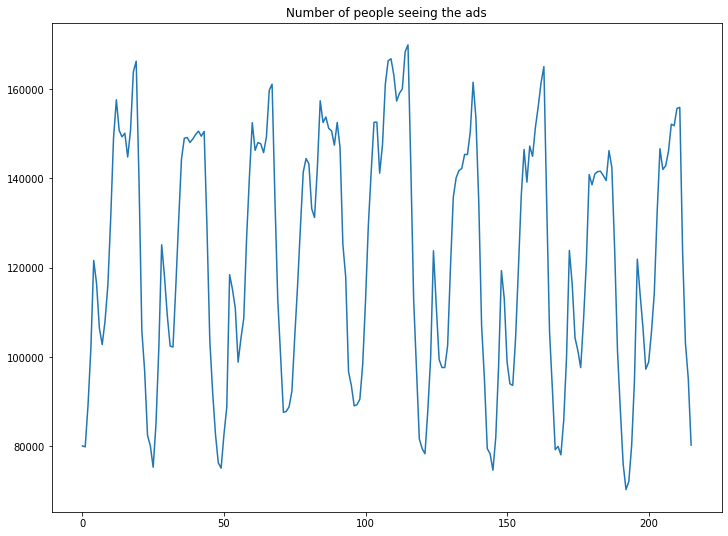

In [ ]:
fig = plt.figure(figsize=(12,9))
pd.Series(df.Ads).plot(title='Number of people seeing the ads')

# **Tester si un bruit blanc ?**

In [ ]:
import statsmodels.api as sm

res = sm.stats.acorr_ljungbox(df.Ads, lags=[5])
print(f"p-value = {res[1][0]}")

p-value = 7.40032305604854e-71


donc la p-value <<<< 0.05

On  peut  rejeter le H0

donc on accept H1: The processus is not independently distributed.

It's not a white noise 

# **Stationnaire ?**

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = df.Ads
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.089634
p-value: 0.000000


p-value <<< 0.05

Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 

Let's see what the plots have to say on this matter. 

In [ ]:
# Test KPSS

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df.Ads)

KPSS Statistic: 0.0851587943559007
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

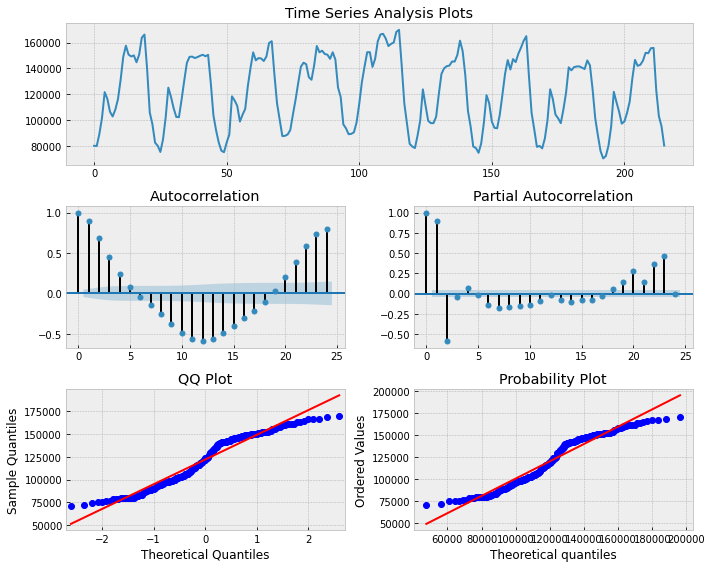

In [ ]:
tsplot(df.Ads)

Our time series have cyclic behavior (but with no trend or seasonality) is stationary.   

D'aprés partial autocorrealtion plot on peut dire que AR est de l'ordre est 2 (nombre de pics)

D'aprés autocorrealtion plot on peut dire que Moving average est de l'ordre est ........ 



In [47]:
mdl = smt.AR(df.Ads).fit(maxlag=10, ic='aic', trend='nc')
est_order = smt.AR(df.Ads).select_order(maxlag=10, ic='aic', trend='nc')

print('\ncoef estimate: {}' .format(est_order))



coef estimate: 4


In [48]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(df.Ads).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(df.Ads).select_order(
    maxlag=max_lag, ic='aic', trend='nc')
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))


coef estimate: 1.6147 -0.6835 | best lag order = 4


In [38]:
max_lag = 30
mdl = smt.ARMA(df.Ads, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                    Ads   No. Observations:                  216
Model:                     ARMA(0, 1)   Log Likelihood               -2702.185
Method:                           mle   S.D. of innovations          65230.612
Date:                Wed, 27 Jan 2021   AIC                           5408.369
Time:                        11:46:03   BIC                           5415.120
Sample:                             0   HQIC                          5411.096
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.Ads      0.9522      0.014     68.393      0.000       0.925       0.980
                                    Roots                                    
                  Real          Imaginary           M

# modelisation AR sur la difference


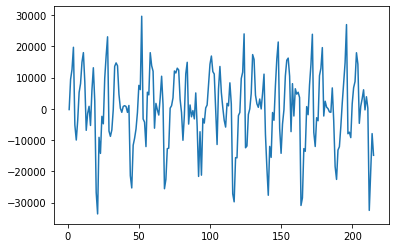

In [13]:
d = df.Ads.diff()
d = d[~d.isna()]

d.plot()


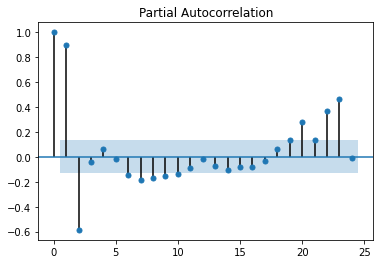

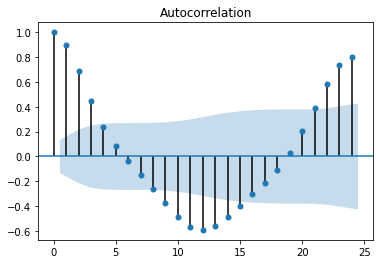

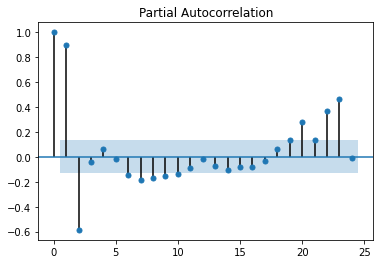

In [14]:
smt.graphics.plot_acf(df.Ads.values)
smt.graphics.plot_pacf(df.Ads.values)


In [ ]:
mdl = smt.AR(d.values).fit(maxlag=4, ic='bic', trend='c')

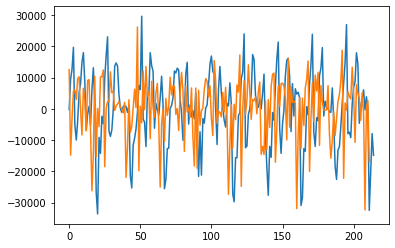

In [16]:
plt.plot(d.values)
plt.plot(mdl.resid)

# decomposer avec statsmodel seasonal_decompose()


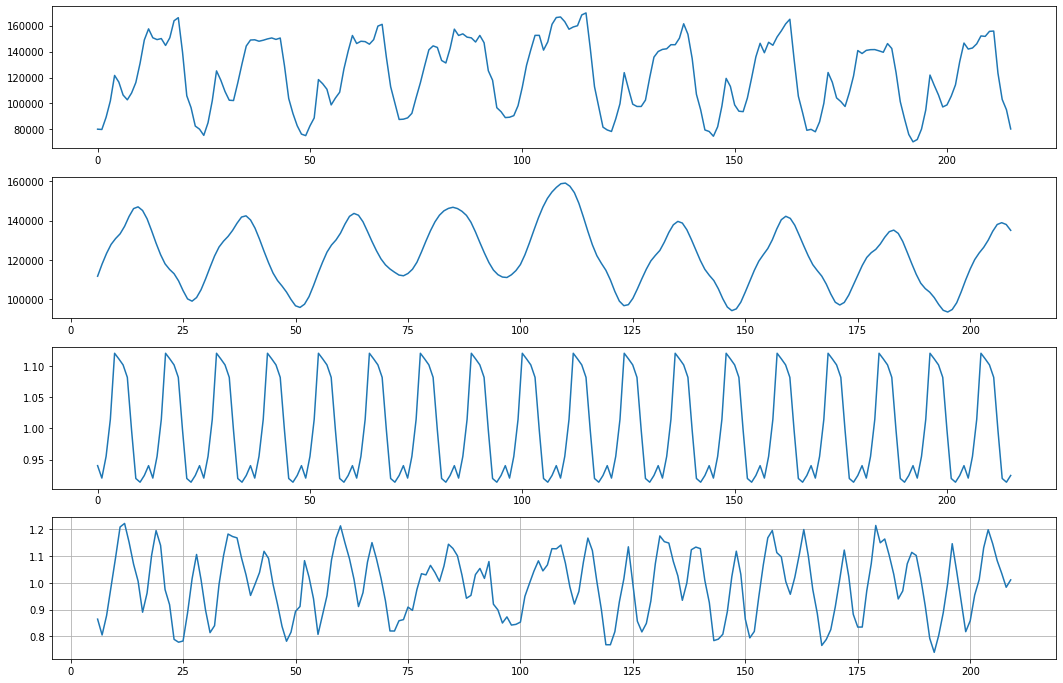

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Ads, model='multiplicative', period =12)

fig, ax = plt.subplots(4,1, figsize = (18,12))
plt.subplot(4,1,1)
plt.plot(df.Ads.values)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.subplot(4,1,4)
plt.plot(result.resid)
plt.grid()

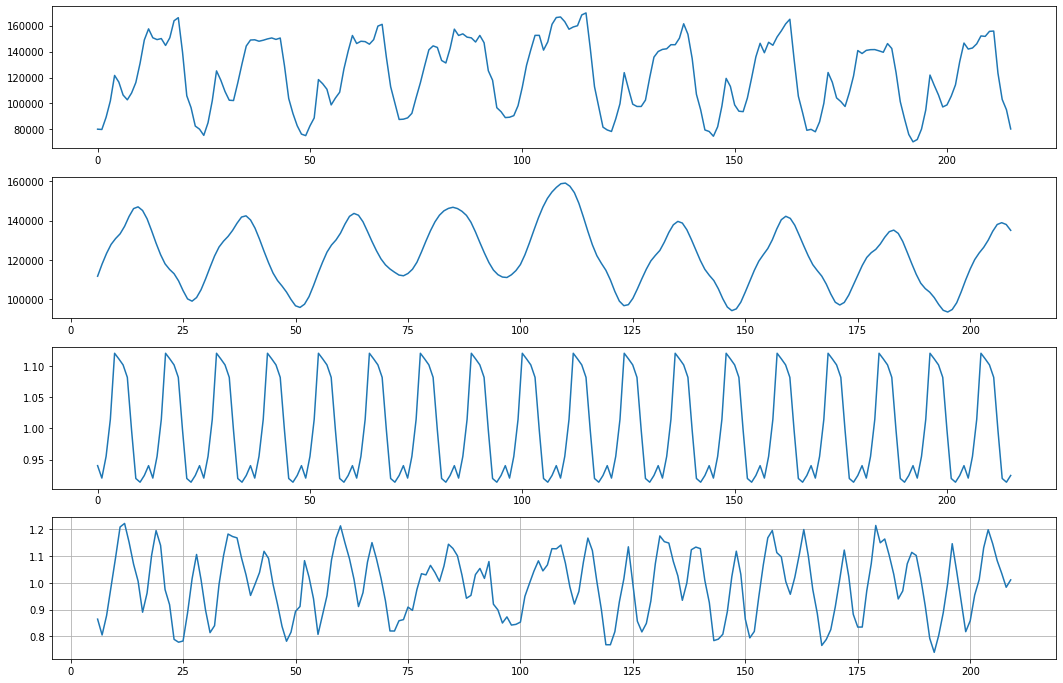

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Ads, model='multiplicative', period =12)

fig, ax = plt.subplots(4,1, figsize = (18,12))
plt.subplot(4,1,1)
plt.plot(df.Ads.values)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.subplot(4,1,4)
plt.plot(result.resid)
plt.grid()

In [7]:
from statsmodels.tsa.seasonal import STL

In [9]:
res = STL(df.Ads, robust = True, period = 12).fit() 

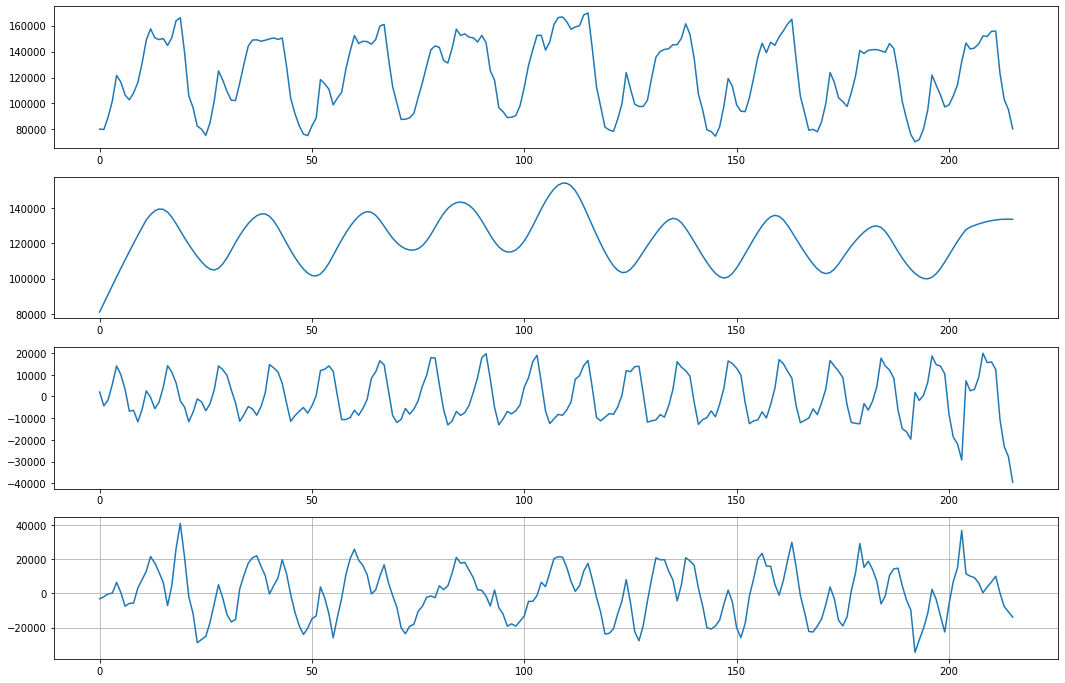

In [11]:
fig, ax = plt.subplots(4,1, figsize = (18,12))
plt.subplot(4,1,1)
plt.plot(df.Ads.values)
plt.subplot(4,1,2)
plt.plot(res.trend)
plt.subplot(4,1,3)
plt.plot(res.seasonal)
plt.subplot(4,1,4)
plt.plot(res.resid)
plt.grid()

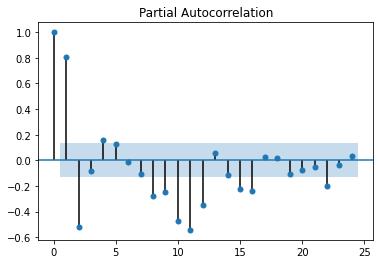

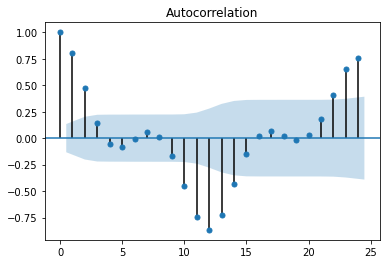

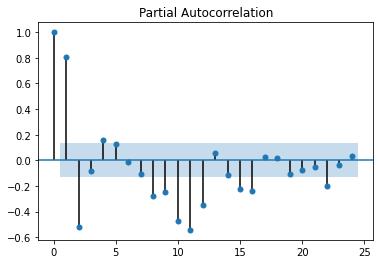

In [12]:
smt.graphics.plot_acf(res.resid)
smt.graphics.plot_pacf(res.resid)